In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [57]:
tickers = ['TSLA', 'GOOGL', 'GM', 'NVDA', 'APTV']
begin_date = '2016-01-01'
end_date = '2024-05-24'

In [58]:
# Fetch stock data
def fetch_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    data = data.pct_change() * 100  # Calculate daily percentage change
    return data

# Fetch stock data
stock_data = fetch_stock_data(tickers, begin_date, end_date)

# Drop NaN values resulting from pct_change calculation
stock_data.dropna(inplace=True)

# Display the head of the stock data for verification
print(stock_data.head())

[*********************100%%**********************]  5 of 5 completed

Ticker          APTV        GM     GOOGL      NVDA      TSLA
Date                                                        
2016-01-05 -2.774135 -2.641852  0.275202  1.606427  0.008952
2016-01-06 -2.657364 -3.576934 -0.288894 -4.134992 -1.964820
2016-01-07 -5.598187 -4.093382 -2.413970 -3.964478 -1.547661
2016-01-08 -1.945627 -1.533842 -1.361667 -2.146636 -2.156275
2016-01-11  3.071491  2.438196  0.295516  0.168752 -1.492891


In [20]:
# Upload the data
from google.colab import files
uploaded = files.upload()

In [59]:
sentiment_df_2016 = pd.read_csv('2016_predicted_sentiment.csv', parse_dates=['date'])
sentiment_df_2016['sentiment_binary'] = sentiment_df_2016['sentiment'].apply(lambda x: 0 if x == -1 else 1)
sentiment_df_2016.head()

,date,text,label,sentiment_label,sentiment_score,sentiment,sentiment_binary
0,2016-01-04,"General Motors, Gazing at Future, Invests $500...",NaN,POSITIVE,0.936707,1,1
1,2016-01-04,G.M.’s Investment in Lyft Hedges Against a Fut...,NaN,POSITIVE,0.843959,1,1
2,2016-01-05,Carmakers Set to Grab Spotlight at Internation...,NaN,POSITIVE,0.997886,1,1
3,2016-01-06,"On Display at CES, Tech Ideas in Their Awkward...",NaN,NEGATIVE,0.998428,-1,0
4,2016-01-07,Carmakers Forge Ahead With Electric Vehicles ...,NaN,POSITIVE,0.996091,1,1


In [72]:
def merge_data(sentiment_data, stock_data):
    sentiment_data['date'] = pd.to_datetime(sentiment_data['date']).dt.tz_localize(None)
    merged_df = pd.merge(sentiment_data, stock_data, left_on='date', right_index=True)
    merged_df.drop(columns=['label'], inplace=True)
    return merged_df.dropna()

# Merge data
merged_df = merge_data(sentiment_df_2016, stock_data)
print(merged_df)

          date                                               text  \
2   2016-01-05  Carmakers Set to Grab Spotlight at Internation...   
3   2016-01-06  On Display at CES, Tech Ideas in Their Awkward...   
4   2016-01-07  Carmakers Forge Ahead With Electric Vehicles  ...   
5   2016-01-08  Insurers Brace for the Self-Driving Future and...   
7   2016-01-12  Volvo Makes a Comeback, With a Detour Through ...   
..         ...                                                ...   
495 2024-04-09  Tesla Settles Lawsuit Over a Fatal Crash Invol...   
496 2024-04-23  Tesla’s Profit Fell 55%, Adding to Concerns Ab...   
497 2024-05-01  China’s Electric Cars Keep Improving, a Worry ...   
498 2024-05-06  Wayve, an A.I. Start-Up for Autonomous Driving...   
499 2024-05-08  Billions in Chips Grants Are Expected to Fuel ...   

    sentiment_label  sentiment_score  sentiment  sentiment_binary      APTV  \
2          POSITIVE         0.997886          1                 1 -2.774135   
3          NE

In [73]:
# Engineer features for the past 28 days for each stock
def create_lagged_features(df, columns, lag_days):
    lagged_data = pd.DataFrame(index=df.index)
    for column in columns:
        for lag in range(1, lag_days + 1):
            lagged_data[f'{column}_lag_{lag}'] = df[column].shift(lag)
    df = pd.concat([df, lagged_data], axis=1)
    df = df.dropna()
    return df

# Apply lagged features
lag_days = 14
merged_df = create_lagged_features(merged_df, tickers, lag_days)

print(merged_df.head())

         date                                               text  \
18 2016-04-12  Facebook’s Developer Conference Kicks Off On T...   
19 2016-04-13  Ford’s Planned New Headquarters Borrow Some Si...   
20 2016-04-22  Despite Strong Earnings, G.M. Has Much to Prov...   
21 2016-04-27  Ford and Google Team Up to Support Driverless ...   
22 2016-05-03  Google to Get Fiat Chrysler Minivans for Self-...   

   sentiment_label  sentiment_score  sentiment  sentiment_binary      APTV  \
18        POSITIVE         0.686108          1                 1 -0.371802   
19        NEGATIVE         0.677211         -1                 0  5.625432   
20        NEGATIVE         0.997127         -1                 0 -0.355260   
21        NEGATIVE         0.871993         -1                 0 -1.091558   
22        POSITIVE         0.997987          1                 1 -0.732601   

          GM     GOOGL      NVDA  ...  APTV_lag_5  APTV_lag_6  APTV_lag_7  \
18  0.609544  0.895004 -0.111485  ...    2.29

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare training and testing data
def prepare_training_data(df, target_column, feature_columns):
    features = df[feature_columns].values
    target = df[target_column].values
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X_train, X_test, y_train, y_test

# Define feature columns
feature_columns = [f'{ticker}_lag_{lag}' for ticker in tickers for lag in range(1, lag_days + 1)]
target_column = 'sentiment_binary'

# Prepare the data
X_train, X_test, y_train, y_test = prepare_training_data(merged_df, target_column, feature_columns)


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# LSTM model
def train_lstm(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(512))
    model.add(Dropout(0.45))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=40, epochs=30, validation_data=(X_test, y_test), verbose=1)
    loss, accuracy = model.evaluate(X_test, y_test)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)

    print(f'Accuracy: {acc}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    return history, model, acc

history, model, acc = train_lstm(X_train, y_train, X_test, y_test)


Epoch 1/30
9/9 [==============================] - 20s 2s/step - loss: 0.6600 - accuracy: 0.6347 - val_loss: 0.6660 - val_accuracy: 0.6429
Epoch 2/30
9/9 [==============================] - 14s 2s/step - loss: 0.6522 - accuracy: 0.6467 - val_loss: 0.6508 - val_accuracy: 0.6429
Epoch 3/30
9/9 [==============================] - 14s 2s/step - loss: 0.6336 - accuracy: 0.6737 - val_loss: 0.6510 - val_accuracy: 0.6429
Epoch 4/30
9/9 [==============================] - 14s 2s/step - loss: 0.6415 - accuracy: 0.6737 - val_loss: 0.6456 - val_accuracy: 0.6429
Epoch 5/30
9/9 [==============================] - 14s 2s/step - loss: 0.6302 - accuracy: 0.6796 - val_loss: 0.6449 - val_accuracy: 0.6429
Epoch 6/30
9/9 [==============================] - 15s 2s/step - loss: 0.6345 - accuracy: 0.6737 - val_loss: 0.6445 - val_accuracy: 0.6429
Epoch 7/30
9/9 [==============================] - 14s 2s/step - loss: 0.6278 - accuracy: 0.6737 - val_loss: 0.6526 - val_accuracy: 0.6429
Epoch 8/30
9/9 [==================

3/3 [==============================] - 2s 233ms/step
Accuracy: 0.6428571428571429
Confusion Matrix:
[[54  0]
 [30  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        54
           1       0.00      0.00      0.00        30

    accuracy                           0.64        84
   macro avg       0.32      0.50      0.39        84
weighted avg       0.41      0.64      0.50        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


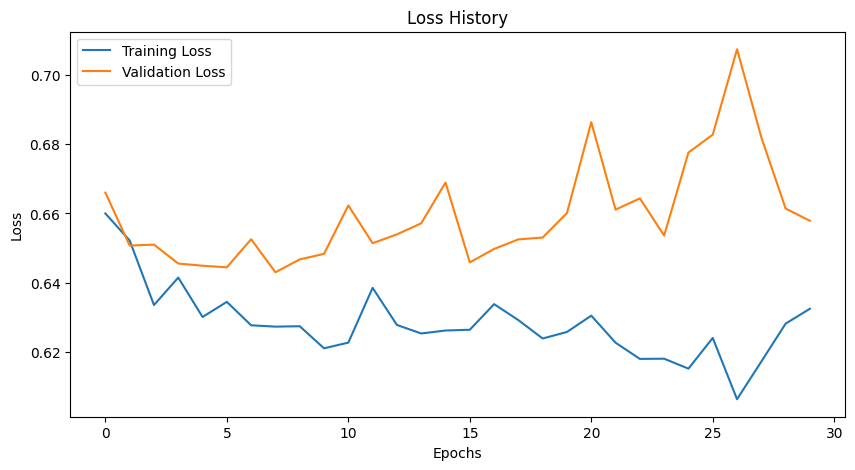

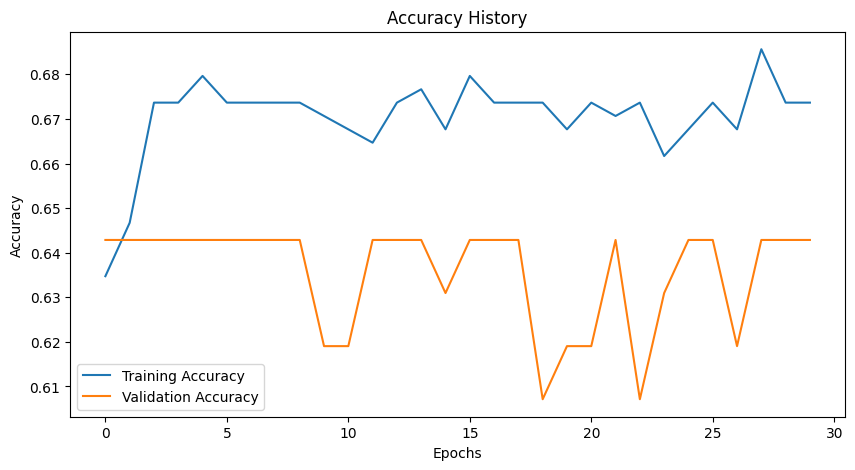

Final Test Accuracy: 0.6428571428571429


In [70]:
# Plot the loss and accuracy history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy
print(f'Final Test Accuracy: {acc}')
